<h1>Clearning of Chemical Data</h1>

In [1]:
import math
import pandas as pd

In [2]:
df_cyp = pd.read_csv('Cytochrome_P450_3A4-chembl31.csv', sep='\t')

In [3]:
# print the first line of the dataframe to see the dataframe structure
df_cyp.loc[0].T

assay_description     Inhibition of cytochrome P450 3A4 of isolated ...
canonical_smiles      Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...
document_journal                               Bioorg. Med. Chem. Lett.
document_year                                                    2004.0
molecule_chembl_id                                         CHEMBL152968
relation                                                              =
standard_relation                                                     =
standard_type                                                      IC50
standard_units                                                       nM
standard_value                                                  37000.0
type                                                               IC50
units                                                                uM
value                                                              37.0
Name: 0, dtype: object

In [4]:
# Delete unnecessary columns
df_cyp = df_cyp.drop(['relation', 'type', 'units', 'value'], axis=1)

# Covert `standard_value` column containing strings and NaN values to floats 
df_cyp['standard_value'] = df_cyp['standard_value'].astype(float)

# and leave molecules whose activity is greater than 0
df_cyp = df_cyp[df_cyp['standard_value'] > 0]

# Delete rows with missing data in the `canonical_smiles` columns
df_cyp = df_cyp.dropna(subset=['canonical_smiles']).reset_index(drop=True)

In [6]:
print('Number of left molecules:', df_cyp.shape[0])

Number of left molecules: 10254


<h2>Unify the bioactivity values of molecules</h2>

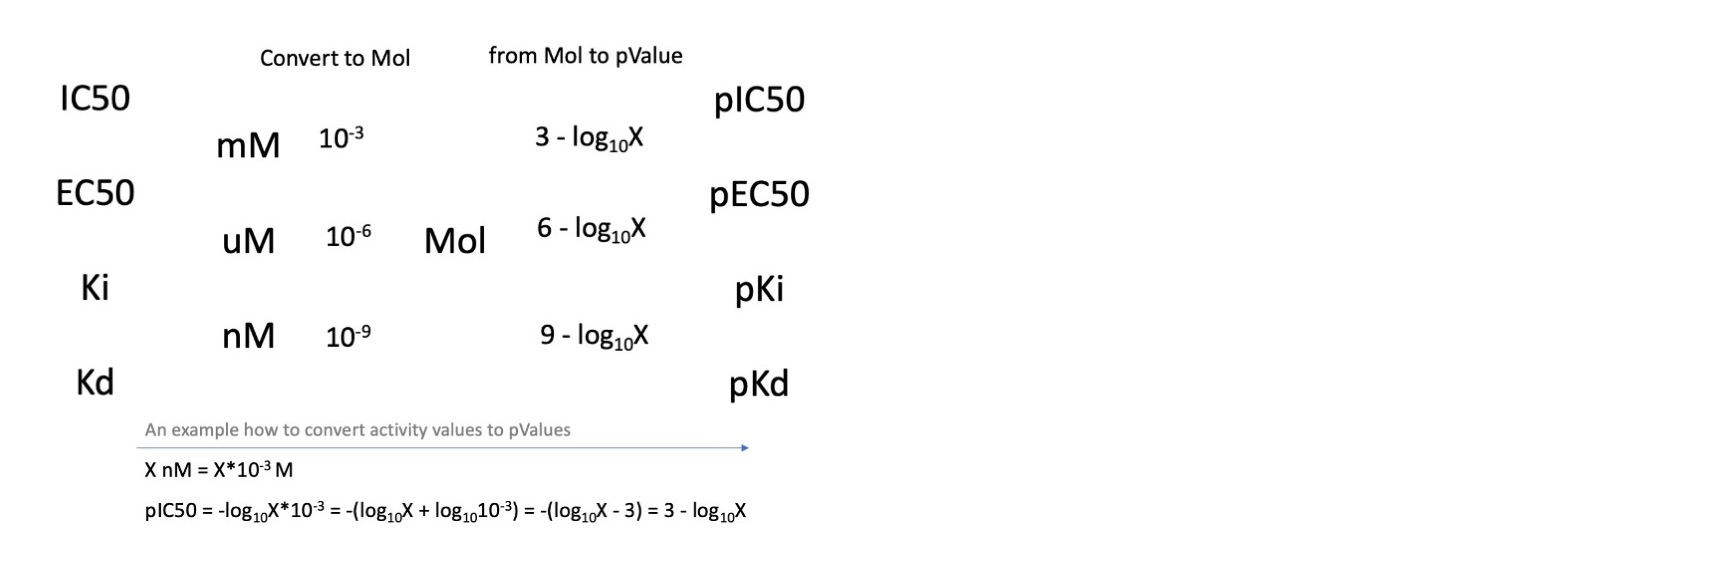

In [ ]:
df_cyp['pval'] = df_cyp.apply(lambda x: 
       round(3 - math.log10(x['standard_value']), 3) if x['standard_units'] == 'mM' 
  else round(6 - math.log10(x['standard_value']), 3) if x['standard_units'] == 'uM' 
  else round(9 - math.log10(x['standard_value']), 3) if x['standard_units'] == 'nM' 
  else None, 
              axis=1)

In [ ]:
# Let's calculate the statistics of the bioactivity values of molecules
print(df_cyp['pval'].describe())
df_cyp['pval'].hist()

<h2>Processing duplicates</h2>

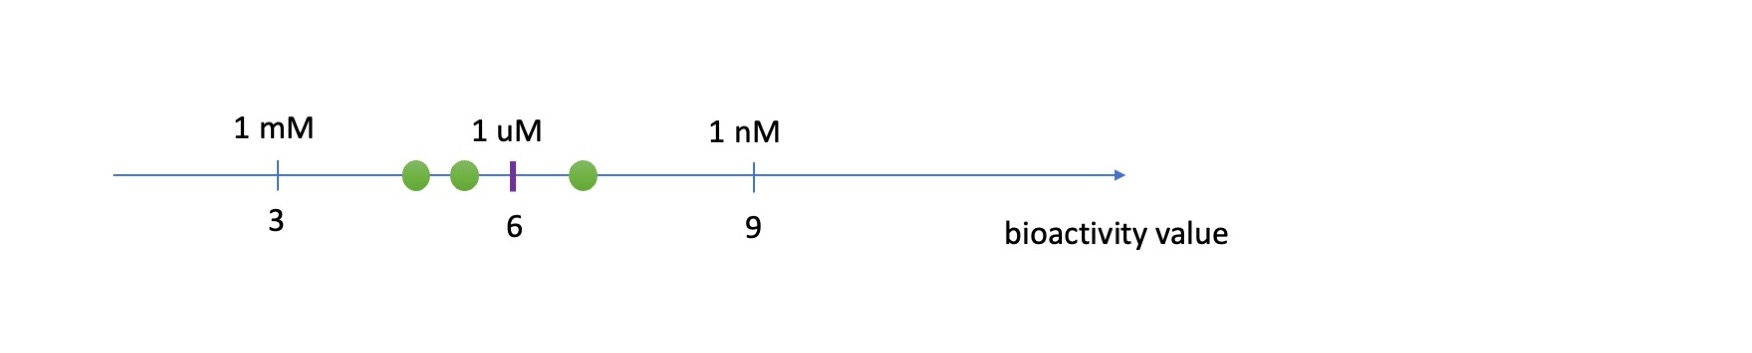

In [ ]:
# calculate the minimum, maximum and arithmetic mean values of the biological activity of duplicated molecules
df_val = df_cyp.groupby('canonical_smiles')['pval'].agg(['mean', 'max', 'min', 'std'])

In [ ]:
# print molecules which have activity values more then 6 and less then 6 at the same time
df_val[(df_val['max'] > 6) & (df_val['min'] <= 6)]

In [ ]:
# collect molecules bioactivity values of which 
distrust_mols = df_val[(df_val['max'] > 6.01) & (df_val['min'] <= 6)].index.tolist()

# remove this molecules from the dataset
df_val = df_val[~df_val.index.isin(distrust_mols)]

In [ ]:
# add the mean of the bioactive values of duplicates to the main dataframe
df_cyp = df_cyp.merge(df_val, left_on='canonical_smiles', right_index=True, how='inner')

# drop the duplicate SMILES
df_cyp = df_cyp.drop_duplicates('canonical_smiles').reset_index(drop=True)

<h2>Classify the compounds into active and inactive</h2>

When we have processed the duplicates, we can now classify the molecules as active and inactive. And here it is worth considering 2 special cases, which are shown in the figure. It is difficult to assess the activity of such molecules, so it is better to exclude them from the sample

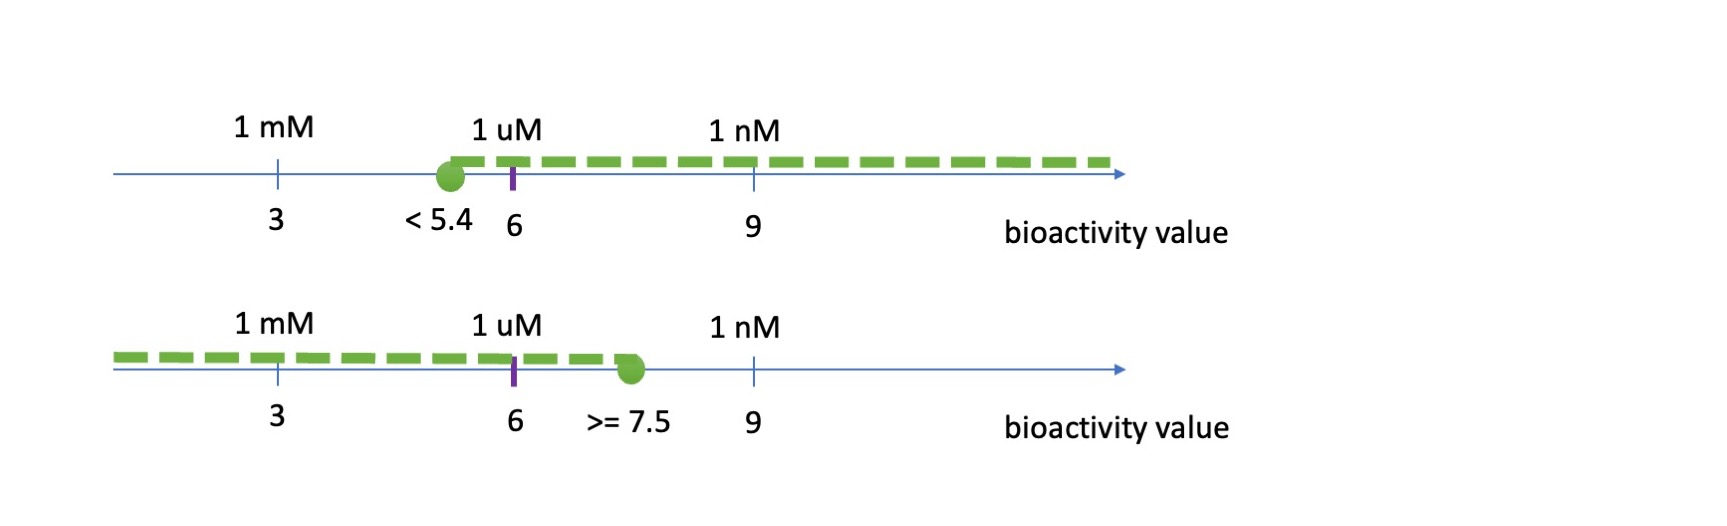

In [ ]:
# If molecules have relation '=' or '>' and mean pActivity >= 6, then the molecules considered active and get status 1
# if molecules have relation '=' or '<' and mean pActivity < 6, then the molecules considered active and get status 0
# otherwise molecules get status None and will be deleted 
df_cyp['status'] = [1 if standard_relation in ['=', '>'] and pvalue >= 6 else 0
                      if standard_relation in ['=','<'] and pvalue < 6 else None
                     for standard_relation, pvalue in zip(df_cyp['standard_relation'], df_cyp['mean'])]

In [ ]:
# We delete the rows in which the values in the status column are missing
df_cyp = df_cyp.dropna(subset=['status']).reset_index(drop=True)

In [ ]:
# build a histogram of bioactivities
df_cyp['mean'].hist()

In [ ]:
# show how many active and inactive molecules in the set
s = df_cyp.groupby(['status']).size()
s.plot(kind='pie', title='Number of active and inactive molecules', figsize=[6,6], 
       autopct=lambda p:f'{p:.2f}% ({p*sum(s.tolist())/100:.0f})')

<h1>SMILES Standartization and Normalization</h1>

<hr>

The standardization of the molecule and normalization of functional groups pipeline using rdkit was proposed by [JP Ebejer](https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/).

In [ ]:
from IPython.display import SVG 

import rdkit
from rdkit import Chem
from rdkit.Chem import rdDepictor  
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.MolStandardize import rdMolStandardize

In [ ]:
def draw_mol_with_SVG(mol, molSize=(450,150)):
    """Use SVG to draw an RDKit molecule, mol."""
    
    # Compute 2D coordinates
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():        
        rdDepictor.Compute2DCoords(mc)
    
    # Draw the molcule
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc) 
    drawer.FinishDrawing()
    
    # Get the SVG string and Display
    svg = drawer.GetDrawingText() 
    display(SVG(svg.replace('svg:','')))

In [ ]:
def standardize_mol(mol, verbose=False):    
    clean_mol = rdMolStandardize.Cleanup(mol) 
    if verbose:
        print('Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:')
        draw_mol_with_SVG(clean_mol)
        
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    if verbose:
        print('Select the "parent" fragment:')
        draw_mol_with_SVG(parent_clean_mol)
        
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    if verbose:
        print('Neutralize the molecule:')
        draw_mol_with_SVG(uncharged_parent_clean_mol)

    te = rdMolStandardize.TautomerEnumerator()
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    if verbose:
        print('Enumerate tautomers:')
        draw_mol_with_SVG(taut_uncharged_parent_clean_mol)
    assert taut_uncharged_parent_clean_mol != None
    
    return taut_uncharged_parent_clean_mol


def standardize_smiles(smiles, verbose=False):
    if verbose: print(smiles)
    std_mol = standardize_mol(Chem.MolFromSmiles(smiles), verbose)
    return Chem.MolToSmiles(std_mol)

In [ ]:
# We can look at each steps of the standardization of a molecule
standardize_smiles(df_cyp.loc[40, 'canonical_smiles'], verbose=True)

In [ ]:
# Standardize all the molecules from the dataset
df_cyp['smiles'] = df_cyp['canonical_smiles'].apply(lambda x: standardize_smiles(x))

In [ ]:
# keep all necessary columns
df_cyp = df_cyp[['smiles', 'molecule_chembl_id', 'mean', 'status']]

# rename the `mean` column to `pval`
df_cyp = df_cyp.rename({'mean': 'pval'}, axis=1)

In [ ]:
# save the dataframe of preprocessed small molecules
df_cyp.to_csv('cyp3a4-clean.smi', sep='\t', index=None)